## Glitch Data Combiner
This function takes glitch data from the Jodrell Bank Centre for Astrophysics' [Pulsar Glitch Catalog](https://www.jb.man.ac.uk/pulsar/glitches/gTable.html) and references it with the [ATNF Pulsar Catalog](https://www.atnf.csiro.au/people/pulsar/psrcat/) in order to add more information about each pulsar in new columns. The attached glitch data was last edited on 23/2/2023, and the ATNF catalog was accessed 15/5/2023, but this code is written with the intention of functioning for updated glitch data tables or edited reference tables, or really any two sets of data with matching pulsar J-names. 

Note that the format of the J-names need to match, and had to be edited even for the data taken from the above catalogs (the code should automatically add Js to names from the JBCA data which don't have them, and identify non J-names). The Bank Centre's data is easily copied into a Google sheet or excel file to be exported as a csv, the ATNF's data is less so. I recommend copy-pasting the ATNF's data into a text file, then using Notepad++ or a similar tool to first find and replace spaces (" ") with commas, then two commas (",,") with commas, repeating until there are no more instances of double commas. This remaining file is then easily imported into excel, although columns of sources for each piece of data and seemingly random columns of numbers will remain, and need to be deleted.

Note that columns used by the code need to have the same names, or the code needs to be edited to match your names. The main thing is to have both J-name columns be called Jname, which is helpful because python doesn't like names with dashes in them (it interprets it as a minus symbol). When pulling data from the ATNF Catalog, it would also work best if you pull P-dot and name it P1, although if you don't the function is commented with instructions on how to get the function running. If you have the correct column names, the last cell can also plot RA vs dec as a sanity check and because it looks cool.

The function takes three inputs. The first is the path to your csv for the glitch data, the second is the path to your csv for the reference data, and the third is the path to the file that you would like to overwrite with your data. In jupyter, just upload a blank csv, give the function its path, and it will overwrite it, or write anything, the function will create a file with that name. The function will do two things, the first is writing a csv to this file, and the second is returning a dataframe which is the same as the csv.

In [4]:
def GlitchCombiner(datapath, referencepath, returnpath):
    import numpy as np
    import pandas as pd
    from pathlib import Path
    data=pd.read_csv(datapath)
    reference=pd.read_csv(referencepath)
    Jnames=data.Jname
    newnames=[] #make a blank list to append to
    for name in Jnames:
        if name[0]=="J":
            newnames.append(name)
        elif name[0]=="0" or name[0]=="1" or name[0]=="2" or name[0]=="3" or name[0]=="4" or name[0]=="5" or name[0]=="6" or name[0]=="7" or name[0]=="8" or name[0]=="9":
            name="J"+name
            newnames.append(name)
        else: #technically having this and the first if statement is inefficient, but this is here in case you want to do something else with these entries
            newnames.append(name)
    data.Jname=newnames
    combined=pd.merge(data,reference,how="left")#merges the data, the left signifies that it is merging with respect to the first dataframe
    badindices=np.where(pd.isna(combined["P0 (s)"])==True)#for this, if you don't have P0, choose a column from the reference dataframe which has entries for each row
    badpulsars=combined.Name[badindices[0]]
    combined=combined.drop(badindices[0])
    combined=combined.reset_index()
    combined.drop(["index"], axis = 1, inplace = True)
    filepath = Path(returnpath)  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    combined.to_csv(filepath,index=False) 
    "if you would like to have the function return either a csv or dataframe of the combined data, or alternatively a table of" 
    "the pulsars which were not recognized, un-comment one of the following three lines, respectively"
    "At most one line should be active at a time"
    return(combined)#I had it return a dataframe because it is the most useful to have within python
    #return(badpulsars)

Text(0, 0.5, 'Declination (degrees)')

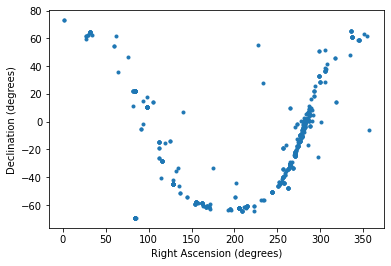

In [13]:
import matplotlib.pyplot as plt
combined=GlitchCombiner("/raid5/homes/owilson/Research_Project/JBCA Glitch Data- 23_2_2023.csv","/raid5/homes/owilson/Research_Project/ATNF Pulsar Data- 15_5_2023.csv","/raid5/homes/owilson/Research_Project/Updated Glitch Data.csv")
plt.plot(combined["RA (deg)"],combined["dec (deg)"],".")
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")

The below function is a "Cleaner" for dataframes generated by the glitch combiner. It is intended to be used if you are calculating or plotting with the dataframe using python. First, the cleaner gets rid of any non-numerical entries in a column, which both the ATNF and JBCA catalogs have a lot of, ususally to indicate a lack of data. Second, it converts each entry to a float, because for whatever reason python initially thinks a lot of the numerical entries are strings, especially from the ATNF columns. 

The function takes two inputs, first the dataframe which you are using, and second the name of the column you want to clean. To clean multiple columns, simply run it multiple times, an example of which I'll leave below. To see which rows were dropped instead, comment out and in the indicated lines.

In [10]:
def Cleaner(dataframe, column):
    df=dataframe
    newcol=[]
    badindices=[]
    for i in range(len(df[column])):
        try:
            float(df[column][i])
        except ValueError:
            badindices.append(i)
    df.drop(badindices, inplace=True)
    df=df.reset_index()
    df.drop(["index"], axis = 1, inplace = True)
    for i in range(len(df[column])):
        x=float(df[column][i])
        newcol.append(x)
    df[column]=newcol
    return(df)# comment out this line and comment in the line below to see which rows were dropped
    #print("The rows corresponding to the following indices were dropped", badindices)

In [20]:
data=GlitchCombiner("/raid5/homes/owilson/Research_Project/JBCA Glitch Data- 23_2_2023.csv","/raid5/homes/owilson/Research_Project/ATNF Pulsar Data- 15_5_2023.csv","/raid5/homes/owilson/Research_Project/Updated Glitch Data.csv")
combined=Cleaner(Cleaner(Cleaner(Cleaner(data,"F1 (Hz/s)"),"dF1/F1 (10^-3)"),"F0 (Hz)"),"dF/F (10^-9)")
combined["dF0 (Hz)"]=combined["dF/F (10^-9)"]*combined["F0 (Hz)"]
combined["dF1 (Hz/s)"]=combined["dF1/F1 (10^-3)"]*combined["F1 (Hz/s)"]
filepath = Path("/raid5/homes/owilson/Research_Project/Updated Glitch Data with dF and dF1")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
combined.to_csv(filepath,index=False)

In [19]:
data=GlitchCombiner("/raid5/homes/owilson/Research_Project/JBCA Glitch Data- 23_2_2023.csv","/raid5/homes/owilson/Research_Project/ATNF Pulsar Data- 15_5_2023.csv","/raid5/homes/owilson/Research_Project/Updated Glitch Data.csv")
combined=Cleaner(Cleaner(data,"F0 (Hz)"),"dF/F (10^-9)")
combined["dF0 (Hz)"]=combined["dF/F (10^-9)"]*combined["F0 (Hz)"]
from pathlib import Path
filepath = Path("/raid5/homes/owilson/Research_Project/Updated Glitch Data with dF")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
combined.to_csv(filepath,index=False)